In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import traceback
import os
import matplotlib.pyplot as plt
import math
from typing import Any

In [14]:
#setup graph and edge properties

qaptesta = np.matrix([[0,1,2,3],
           [1,0,4,5],
           [2,4,0,6],
           [3,5,6,0]])
qaptestb = np.matrix([[0,60,50,10],
            [60,0,30,20],
            [50,30,0,50],
            [10,20,50,0]])

vecta = qaptesta.sum(axis=1)
vectb = qaptestb.sum(axis=1)

graphweights = np.dot(vecta,vectb.T)

print(graphweights)

graph = nx.from_numpy_matrix(np.matrix(graphweights), create_using=nx.DiGraph)
nx.set_edge_attributes(graph,1.0,"pheromone")
nx.set_edge_attributes(graph,'b',"color")
nx.set_edge_attributes(graph,0.0,"heuristic")
nx.set_edge_attributes(graph,0.0,"delta")
layout = nx.kamada_kawai_layout(graph)
for u, v, weight in graph.edges(data="weight"):
    #if(weight is not None):
    print(f'source {u}, dest {v}, weight {weight}')
    graph[u][v]["heuristic"] = 1/weight

4500
source 0, dest 0, weight 4500


In [4]:
#define artificial ant
class Ant():
    
    def __init__(self,startingtown) -> None:
        self._visited = []
        self._tourlength = 0.0
        self._viabletour = True
        self._visited.append(startingtown)
    
    def move(self,newtown,distance):
        self._visited.append(newtown)
        self._tourlength = self._tourlength + distance
    
    def invalidateTour(self):
        self._viabletour = False
    
    def getTour(self) -> list:
        return self._visited
    
    def getTourLength(self) -> float:
        return self._tourlength
    
    def setTourLength(self, newlen) -> None:
        self._tourlength = newlen

    def isTourViable(self) -> bool:
        return self._viabletour
    
    def __lt__(self,other):
        if(self._tourlength<other._tourlength):
            return True
        else:
            return False

    def __gt__(self,other):
        if(self._tourlength>other._tourlength):
            return True
        else:
            return False


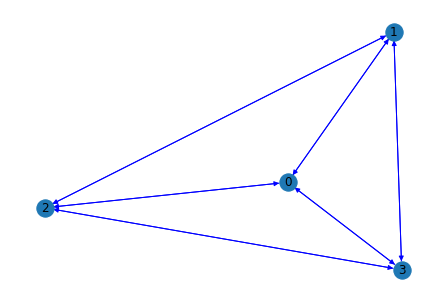

In [3]:
#draw problem graph
edges = graph.edges()
colors = [graph[u][v]['color'] for u,v in edges]
nx.draw(graph, layout, edge_color=colors, with_labels = True)
plt.show()

In [5]:
#Ant Algorithm elements


def fitPropSelectionAS(graph: nx.DiGraph,viable_paths: list,visited: list,args: dict):
    psum = 0
    pvals = []
    for node in viable_paths:
        tmp = math.pow(graph[visited[-1]][node]["heuristic"],args['alpha']) + math.pow(graph[visited[-1]][node]["pheromone"],args['beta'])
        pvals.append(tmp)
        psum = psum + tmp
    pvals = [v/psum for v in pvals]
    next_node = np.random.choice(a=viable_paths,p=pvals)
    return next_node

def ACOProportionalSelecton(graph: nx.DiGraph,viable_paths: list,visited: list,args: dict):
    pvals = []
    if args['q'] > np.random.uniform():
        for node in viable_paths:
            tmp = graph[visited[-1]][node]["heuristic"] + math.pow(graph[visited[-1]][node]["pheromone"],args['beta'])
            pvals.append(tmp)
        return viable_paths[np.argmax(pvals)]
    else:
        return fitPropSelectionAS(graph,viable_paths,visited,args)

def findbest(pop: list):
    best = Ant(0)
    best.setTourLength(100000000.0)
    for ant in pop:
        if ant.isTourViable():
            if ant < best:
                best = ant
    return best

def ASGlobalpheromoneUpdate(graph: nx.DiGraph,population: list, args: dict) -> nx.DiGraph:
    for ant in population:
        #proper solutions only
        if ant.isTourViable(): 
            tour = ant.getTour()
            startnodes = tour[:-1]
            endnodes = tour[1:]
            for s,n in zip(startnodes,endnodes):
                graph[s][n]["delta"] += args['Qval'] / ant.getTourLength()
    evap_coef = 1-args['evaporation']
    for u, v, weight in graph.edges(data="pheromone"):
        graph[u][v]["pheromone"] = evap_coef*graph[u][v]["pheromone"] + graph[u][v]["delta"]
    nx.set_edge_attributes(graph,0.0,"delta")
    return graph

def ACOGlobalPheromoneUpdate(graph: nx.DiGraph,population: list, args: dict):
    evap_coef = 1-args['evaporation']
    best = args['globalbest']
    tour = best.getTour()
    startnodes = tour[:-1]
    endnodes = tour[1:]
    for s,n in zip(startnodes,endnodes):
        graph[s][n]["delta"] += math.pow(best.getTourLength(),-1)
    for u, v, weight in graph.edges(data="pheromone"):
        graph[u][v]["pheromone"] = (evap_coef*graph[u][v]["pheromone"]) + (args['evaporation']*graph[u][v]["delta"])
    nx.set_edge_attributes(graph,0.0,"delta")
    return graph

def MMASGlobalPheromoneUpdate(graph: nx.DiGraph,population: list, args: dict):
    evap_coef = 1-args['evaporation']
    best = findbest(population)
    tour = best.getTour()
    startnodes = tour[:-1]
    endnodes = tour[1:]
    delta = 1/best.getTourLength()
    for s,n in zip(startnodes,endnodes):
        graph[s][n]['pheromone'] = (evap_coef*graph[s][n]['pheromone']) + delta
        if graph[s][n]['pheromone'] > args['max_pheromone']:
            graph[s][n]['pheromone'] = args['max_pheromone']
        elif graph[s][n]['pheromone'] < args['min_pheromone']:
            graph[s][n]['pheromone'] = args['min_pheromone']
    return graph

def NoLocalUpdate(graph: nx.DiGraph,lastnode: Any, newnode: Any, taboo: list, args: dict):
    return graph

def ACOLocalUpdateTau0(graph: nx.DiGraph, lastnode: Any, newnode: Any, taboo: list, args: dict):
    evap_coef = 1-args['evaporation']
    one = evap_coef*graph[lastnode][newnode]['pheromone']
    two = args['evaporation']*args['startpheromone']
    graph[lastnode][newnode]["pheromone"] = one + two
    return graph

def ACOLocalUpdateQlearning(graph: nx.DiGraph, lastnode: Any, newnode: Any, taboo: list, args: dict):
    evap_coef = 1-args['evaporation']
    nextnodes = [x for x in [n for n in graph[newnode]] if x not in taboo]
    if len(nextnodes) == 0:
        return ACOLocalUpdateTau0(graph,lastnode,newnode,taboo,args)
    else:
        nextphero = []
        for node in nextnodes:
            nextphero.append(graph[newnode][node]['pheromone'])
        delta = args['gamma']*np.max(nextphero)
        one = evap_coef*graph[lastnode][newnode]['pheromone']
        two = args['evaporation']*delta
        graph[lastnode][newnode]["pheromone"] = one + two
        return graph
    
def MMAStaumax(graph: nx.DiGraph, bestlength: float, args: dict):
    one = 1/(1-args['evaporation'])
    two = 1/bestlength
    max_pheromone = one * two
    args['max_pheromone'] = max_pheromone
    return args

def MMAStaumin(graph: nx.DiGraph, args: dict):
    n = graph.number_of_nodes()
    p = args['prob']**(1/n)
    av = n/2
    min_pheromone = (args['max_pheromone']*(1-p))/((av-1)*p)
    args['min_pheromone'] = min_pheromone
    return args

def MMASTrailSmoothing(graph: nx.DiGraph, args: dict):
    for u, v, pheromone in graph.edges(data="pheromone"):
        graph[u][v]["pheromone"] = pheromone + args['smoothing_coef']*(args['max_pheromone']-pheromone)
    return graph

In [6]:
#define AS algorithm
def AntSystemAlgorithm(problem: nx.DiGraph, pop_count: int, max_cycles: int, nextNodeSelection
                    , globalUpdate, localUpdate, args: dict) -> Ant:
    argslocal = args
    problem = problem
    nx.set_edge_attributes(problem,args['startpheromone'],"pheromone")
    population = []
    globalbest = Ant(0)
    globalbest.setTourLength(100000000.0)
    argslocal['globalbest'] = globalbest
    localbest = Ant(0)
    localbest.setTourLength(100000000.0)
    for i in range(0,max_cycles):
        print(f'cycle {i}')
        population = []
        for i in range(0,pop_count):
            population.append(Ant(0))
        for j in range(0,len(problem)-1):
            for ant in population:
                visited = ant.getTour()
                viable_paths = [x for x in [n for n in problem[visited[-1]]] if x not in visited]
                if len(viable_paths) == 0:
                    if j < len(problem)-1:
                        ant.invalidateTour()
                    pass
                else:
                    next_node = nextNodeSelection(problem,viable_paths,visited,argslocal)
                    localUpdate(problem,visited[-1],next_node,visited,argslocal)
                    ant.move(next_node,problem[visited[-1]][next_node]["weight"])
                #ants have moved 1 node ahead
            #most ants now have a solution ready
        #post cycle pheromone updates and solution assesment
        #review population
        localbest = findbest(population)
        if localbest < globalbest:
            globalbest = localbest
            argslocal['globalbest'] = globalbest
        problem = globalUpdate(problem,population,argslocal)
    return problem, globalbest


cycle 0
cycle 1
cycle 2
cycle 3


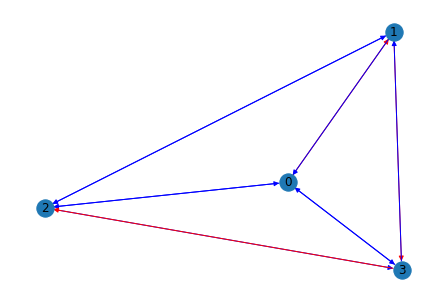

In [7]:
args = {
    'alpha': 0.5,
    'beta': 0.6,
    'Qval': 2,
    'evaporation': 0.5,
    'q': 0.5,
    'startpheromone': 2.0,
    'globalbest': [],
    'gamma': 0.5,
    'prob': 0.05,
    'max_pheromone': 2.0,
    'min_pheromone': 0.5,
    'smoothing_coef': 0.8
}

graph, solution = AntSystemAlgorithm(graph,4,4,ACOProportionalSelecton,ACOGlobalPheromoneUpdate,ACOLocalUpdateTau0,args)
besttour = solution.getTour()
startnodes = besttour[:-1]
endnodes = besttour[1:]
for s,n in zip(startnodes,endnodes):
    graph[s][n]["color"] = 'r'
edges = graph.edges()
colors = [graph[u][v]['color'] for u,v in edges]
nx.draw(graph, layout, edge_color=colors, with_labels = True)